# Transductive On-Disk Pipeline

## Tutorial Overview

In this tutorial, we present three transductive dataset pipelines designed for scalable higher-order learning in TopoBench.  
These pipelines progressively increase in memory efficiency, moving from fully-in-memory processing to a fully on-disk workflow suitable for large graphs.

The goal of this notebook is to demonstrate:

- **How each pipeline works**,  
- **How to configure and run them**, and  
- **How to evaluate and compare their memory and performance characteristics**.

---

## Why Three Pipelines?

TopoBench was originally built around the `InMemoryDataset` class from `torch_geometric`, which works well for small and medium-sized graphs.  
However, when dealing with larger datasets or applying computationally expensive topological liftings, the memory requirements quickly become prohibitive.

To overcome these limitations, we introduce two additional pipelines for transductive datasets that extend the original design and enable more memory efficient transductive processing:

### 1. Standard TopoBench Pipeline
- Loads the entire graph into memory as an `InMemoryDataset`.
- Applies all preprocessing, liftings, and split generation fully in RAM.
- Simple and fast for small graphs, but becomes slow and memory-intensive for large datasets or heavy lifting operations.
- Not suitable when the full lifted structure exceeds available memory.

### 2. Cluster-GCN–Style Partitioning Pipeline
- Loads the full graph into memory once, runs a Cluster-GCN–style partitioner, and writes the partitioned representation to disk.
- Used primarily to prepare datasets for the fully on-disk pipeline (Pipeline 3).
- During training, batches are formed by selecting a few clusters, collating them together, and performing liftings at batch level. This preserves message passing across clusters inside the batch while keeping memory usage low.
- After partitioning is complete, subsequent runs no longer require the full graph in RAM.

### 3. Fully On-Disk Transductive Pipeline
- Downloads a pre-partitioned dataset prepared via Pipeline 2 and hosted online.
- All data structures (features, edges, adjacency/chains, and cluster assignments) are accessed from disk, so we never load the graph into memory.
- The training loop performs the same batch-level lifting as Pipeline 2.
- Enables training on very large graphs by preparing the partitioned dataset once on a high-RAM machine once (via Pipeline 2) and then training anywhere using only the lightweight on-disk representation.

---

## What This Notebook Covers

This notebook walks through the following:

### 1. Understanding New Pipelines
We explain:

- Motivation
- What they add to TopoBench

### 2. Using the Transductive Pipelines in TopoBench
We will demonstrate:

- How to instantiate each pipeline via Hydra configuration  
- How to integrate them into the existing TopoBench mechanisms  
- How to apply lifting transformations at the batch or global level  

### 3. Evaluation, Testing, and Memory Tracking
Finally, we compare the pipelines:

- Performance characteristics  
- Memory footprint (via `memory_plotting.py`)  
- Behavior under randomized cluster batching  
- Recall convergence experiments for higher-order structures

# Understanding New Pipelines
## Motivation: Cluster-GCN

Training GNNs on large transductive graphs presents two core challenges:

#### 1. Full-batch GCNs do not scale

Standard GCNs operate on the entire graph at once. This requires storing all node embeddings for all layers:

$$
\text{Memory} = O(N \times F \times L)
$$

where:
- $N$: number of nodes  
- $F$: feature dimension  
- $L$: number of layers  

As graphs grow, this quickly exceeds available RAM.

---

#### 2. Simple mini-batching breaks down on graphs

If we try to create a mini-batch by sampling a small set of nodes, we cannot run a GNN on them directly. GCN-style message passing requires all their neighbors to be present:

- A 1-layer GCN needs 1-hop neighbors  
- A 2-layer GCN needs 2-hop neighbors  
- An L-layer GCN needs all L-hop neighborhoods

So even if we start with only a few nodes, we must:

- Gather all 1-hop neighbors  
- Then all neighbors of those neighbors  
- Continue for L steps

This process quickly pulls in a very large part of the graph, meaning the “mini-batch” becomes almost as large as the full graph.

This is the key reason standard SGD-style mini-batching does not work for GCNs.

---

Our solution is based on the Cluster-GCN algorithm proposed in Chiang et al., *Cluster-GCN: An Efficient Algorithm for Training Deep and Large GNNs* (KDD 2019). This approach is also used in PyTorch Geometric’s `ClusterData` implementation.

### Cluster-GCN’s Key Insight

Cluster-GCN avoids both problems by batching clusters, not individual nodes:

1. **Partition the graph.**
   Into clusters with strong intra-cluster connectivity (using METIS graph partitioning algorithm)

3. **Each mini-batch consists of one or more clusters.**  
   All message passing occurs inside the induced subgraph of these clusters.

4. **No recursive neighbor expansion** is needed,  
   because the cluster subgraphs already contain the relevant neighbors.

**Benefits:**

- Memory scales with the number of nodes in the batch, not with the total graph size:  
  For a batch containing $b$ nodes: $O(b \times F \times L)$ with $b \ll N$

- Clusters preserve local neighborhood structure:  
  Effective message passing inside each block

- Mini-batches are small but structurally meaningful:
  Avoids low-signal subgraphs caused by purely random node sampling

---

### In TopoBench

TopoBench applies topological liftings that transform graphs into higher-order datasets.  
These operations:

- require more memory than standard GCN preprocessing,  
- make fully in-memory workflows impractical on larger datasets.

By incorporating a Cluster-GCN–style partitioning strategy (following Chiang et al. 2019):

- liftings can be applied at the mini-batch level,  
- memory usage is bounded by cluster size instead of graph size,  
- features and adjacency blocks can be streamed directly from disk,  
- lifted models can be trained on graphs that would otherwise not fit in memory.

This forms the foundation for the new transductive pipelines we implemented.

# Using the Transductive Pipelines in TopoBench

All three transductive pipelines are selected and configured purely through YAML files.

For the Cora dataset, we use three separate YAMLs:

1. `cocitation_cora.yaml`: standard in-memory pipeline  
2. `cocitation_cora_for_partitioning.yaml`: partitioning pipeline (build on-disk dataset)  
3. `cocitation_cora_on_disk.yaml`: fully on-disk training pipeline  

Below we present the other two.

---

## Cluster-GCN–Style Partitioning Pipeline (`cocitation_cora_for_partitioning.yaml`)

To build the on-disk, partitioned dataset, we start from the in-memory YAML and add the lines required for Cluster-GCN-style partitioning.

**Important:**  
We keep the same loader (`PlanetoidDatasetLoader` in this example), because partitioning still requires loading the entire graph into memory once.

```yaml
# cocitation_cora_for_partitioning.yaml

loader:
  _target_: topobench.data.loaders.PlanetoidDatasetLoader   # same as in-memory
  parameters:
    data_domain: graph
    data_type: cocitation_on_disk        # NEW: output directory for the partitioned dataset
    data_name: Cora
    data_dir: ${paths.data_dir}/${dataset.loader.parameters.data_domain}/${dataset.loader.parameters.data_type}

    # NEW: activate Cluster-GCN–style global partitioning
    memory_type: on_disk_cluster          # "in_memory", "on_disk", or "on_disk_cluster"

    # NEW: global partition settings
    cluster:
      num_parts: 32
      recursive: false
      keep_inter_cluster_edges: false
      sparse_format: csr

    # NEW: streaming parameters (these affect how batches will be formed later)
    stream:
      q: 4 # batch size
      num_workers: 0
      pin_memory: false
      with_edge_attr: false
      precompute_split_parts: true

    # NEW: how features are saved on disk
    dtype_policy: float32


---

## Fully On-Disk Pipeline (`cocitation_cora_on_disk.yaml`)

The fully on-disk pipeline is entirely autonomous. It does not require the user to run the partitioning step (Pipeline 2) locally.

Instead, TopoBench provides a registry of pre-partitioned datasets that were already produced using the partitioning pipeline and then uploaded online.

The `OnDiskDatasetLoader` downloads, extracts, and loads this structure directly from disk, without ever loading the full graph into memory.

Because the dataset is already partitioned, the loader used is:

```yaml
loader:
  _target_: topobench.data.loaders.OnDiskDatasetLoader

This distinguishes Pipeline 3 from the partitioning pipeline, where `PlanetoidDatasetLoader` (in the Cora example) is still required to hold the full graph in RAM temporarily.

### Where these datasets come from

Several datasets in TopoBench were already partitioned offline using Pipeline 2 and then hosted in the public repository.  
Pipeline 3 simply consumes these ready-made on-disk datasets via the URLs defined in:

```python
OnDiskDatasetLoader.URLS

This allows Pipeline 3 to run immediately, without requiring the user to
perform any partitioning locally.

Below is the configuration used for the fully on-disk pipeline:

```yaml
# cocitation_cora_on_disk.yaml

loader:
  _target_: topobench.data.loaders.OnDiskDatasetLoader
  parameters:
    data_domain: graph
    data_type: cocitation_on_disk
    data_name: Cora_on_disk          # must match a key in URLS
    data_dir: ${paths.data_dir}/${dataset.loader.parameters.data_domain}/${dataset.loader.parameters.data_type}

    memory_type: on_disk             # fully on-disk mode

    cluster:
      num_parts: 32
      recursive: false
      keep_inter_cluster_edges: false
      sparse_format: csr

    stream:
      q: 4
      num_workers: 0
      pin_memory: false
      with_edge_attr: false
      precompute_split_parts: true

    dtype_policy: float32

The only differences between Pipeline 2 and Pipeline 3 are:

- `memory_type` changes from `on_disk_cluster` to `on_disk`  
- the loader switches from `PlanetoidDatasetLoader` to `OnDiskDatasetLoader`

Everything else (cluster settings, stream configuration, `dtype_policy`) remains identical, because Pipeline 3 uses the already partitioned dataset.

## Adding a New Dataset to the On-Disk URL Registry

To make a new dataset available for the fully on-disk pipeline, you only need to add one entry to the `OnDiskDatasetLoader.URLS` dictionary.

Follow these steps:

### 1. Run Pipeline 2 (on_disk_cluster) on your dataset
This produces a `processed/` directory containing the partitioned graph:
- permuted features  
- CSR adjacency  
- labels and masks  
- cluster boundaries  
- metadata  

### 2. Zip the `processed/` directory
Create a file named `processed.zip` containing all files inside `processed/`.

### 3. Upload the ZIP file
You can host it anywhere that provides a direct download link:
- GitHub  
- HuggingFace  
- Your prefered platform  

### 4. Add an entry to the URL registry
In `OnDiskDatasetLoader.URLS`, add:

```python
"YourDataset_on_disk": "https://your-host.com/path/to/processed.zip"

### 5. Use it in a YAML file

Set:
```yaml
data_name: YourDataset_on_disk

and the `OnDiskDatasetLoader` will automatically download, extract, and load the dataset.

That’s it, your custom dataset is now fully compatible with the on-disk pipeline.

# Evaluation, Testing, and Memory Tracking

## Memory Comparison Across Pipelines

To evaluate the practical memory benefits of our transductive pipelines,  
we measure and visualize RAM usage during training on several variants of the Reddit dataset.

The Reddit dataset is a large-scale, node-classification benchmark introduced in  
*GraphSAGE: Inductive Representation Learning on Large Graphs*.  
It contains:

- **232,965 nodes**  
- **11,606,919 edges**  
- **602-dimensional features**

(See the official PyTorch Geometric implementation:  
https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Reddit.html)

Because of its size, Reddit is an ideal test case for comparing memory footprints.

---

### What We Compare

We evaluate three versions of the same dataset, each processed by a different pipeline:

1. **reddit (in-memory)**  
   - Standard PyG `InMemoryDataset`.  
   - The full graph, features, and adjacency are resident in RAM.  
   - Serves as the *baseline* for maximum memory use.

2. **reddit\_cluster\_2 (partitioning pipeline)**  
   - Produced with Pipeline 2 (`on_disk_cluster`).  
   - Loads the full graph once, partitions it, and trains using cluster-wise batches.  
   - Greatly reduces peak memory use during training.

3. **reddit\_cluster\_3 (fully on-disk pipeline)**  
   - Produced with Pipeline 3 (`on_disk`).  
   - No full graph is stored in memory: features, adjacency, and cluster blocks  
     are streamed from disk on demand.  
   - Achieves the lowest memory footprint.

---

## How Memory Tracking Works

For each configuration, we run the training process under a memory profiler:

1. A template test file is patched with the selected dataset and model.  
2. Training is executed while memory usage is measured continuously.  
3. The profiler outputs:
   - raw memory vs. time, and  
   - normalized memory vs. relative progress,  
     allowing comparison when runtimes differ.

The following plots summarize the results for the three Reddit variants.

### `graph/gcn` model

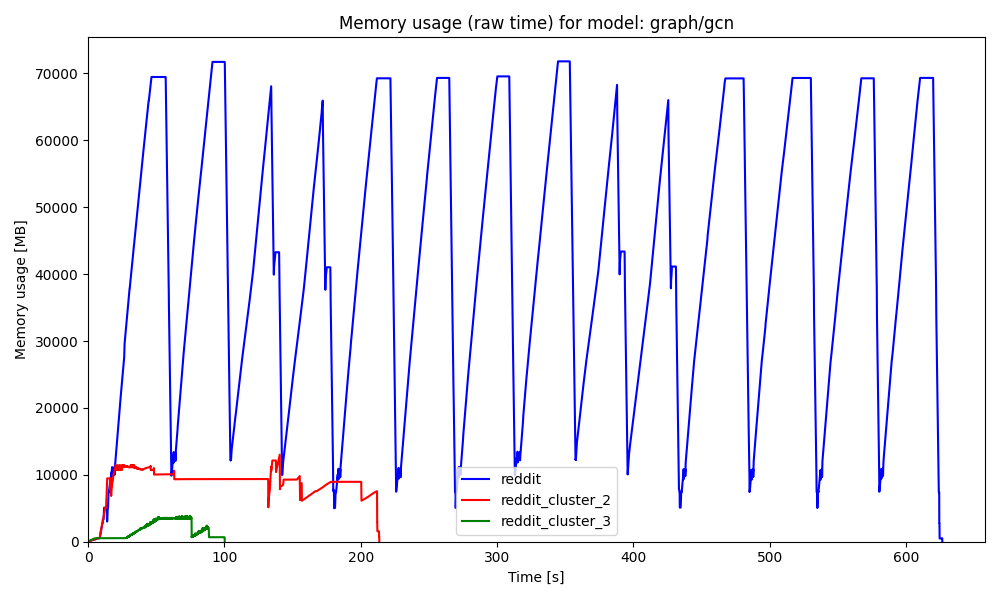

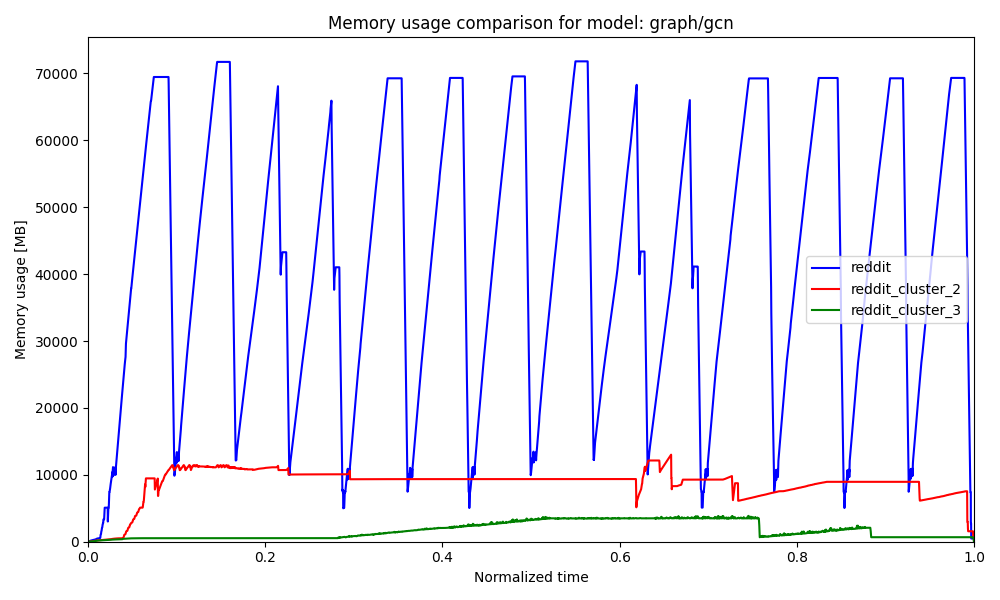

These plots show memory and time savings produced by our pipelines for a large transductive datasets.

# Challenges With Liftings Under Graph Partitioning

Topological liftings are global operations: they detect higher-order structures that may span large portions of the graph.  
However, in a Cluster-GCN–style pipeline, we intentionally partition the graph into many small blocks.

This leads to the central issue:

---

## Local Liftings Lose Global Structure

If liftings are applied inside each cluster independently, then:

- each cluster produces local higher-order structures,
- any structure spanning multiple clusters is lost,
- when clusters are later combined into a batch, their lifted structures remain disjoint,  
- and the dataloader has no mechanism to merge them back into a consistent global structure.

In other words: lifting before batching destroys global higher-order structures.

---

## Our Solution: Batch First, Lift Second

To capture global topological structures as faithfully as possible, we redesigned the pipeline:

1. The Cluster-GCN loader samples several clusters for each batch.  
2. These clusters are collated into a single subgraph.  
3. Liftings are applied to the collated batch, not to each cluster.

This allows:

- structures spanning multiple clusters to be discovered if those clusters co-occur in a batch,
- randomized batching across epochs to progressively reveal additional global structures.

We therefore sweep two parameters:

- `num_parts`: number of METIS partitions,  
- `batch_size`: number of partitions gathered before lifting.

When `batch_size = num_parts`, all partitions are assembled at once and the full graph is reconstructed, producing liftings identical to the global “golden” lifting, which is our fallback position.

---

## Structures Comparison

To quantify how much global information is preserved, we compare against a global lifting:

- Set $G$: all higher-order structures (hyperedges, 1-cells, 2-cells, …) produced by lifting the entire graph, called golden in the rest of the notebook.
- Sets $C^{(i)}$: structures observed in epoch $i$ of the cluster pipeline.

At epoch 1:

- each batch produces lifted structures,
- they are collected into $C^{(1)}$,
- and compared against the golden set $G$.

Across multiple epochs:

- shuffling the batches reveals new cross-cluster structures,
- giving the cumulative set $C^{(\le n)} = \displaystyle \bigcup_{i=1}^{n} C^{(i)}$.

---

## Recall Metrics

We use recall to measure how many global structures are recovered.

### Recall after 1 epoch

$$
\text{Recall}_{1}
= \frac{\lvert\, G \cap C^{(1)} \,\rvert}{\lvert G \rvert}
$$

This quantifies how many golden structures appear after a single randomized sweep.

---

### Cumulative recall after $n$ epochs

$$
\text{Recall}_{n}
= \frac{
    \left|\, G \cap \displaystyle \bigcup_{i=1}^{n} C^{(i)} \,\right|
}{
    \lvert G \rvert
}
$$

This measures the fraction of global structures recovered after repeatedly mixing clusters across $n$ epochs.

---

Below we present the following:

1. Recall after a single epoch  
   — shows how much structure is captured in one pass.

2. Recall after many epochs
   — shows how much structure is recovered through repeated random batching.

3. Final / initial recall ratio  
   — quantifies how much improvement comes from multi-epoch mixing.

4. Recall progression over epochs for  a selected configuration of `batch_size` and `num_parts`.

The heatmaps and line plots that follow illustrate these effects  
for hyperedges, 1-cells, and 2-cells across different `batch_size` and `num_parts` configurations for the Cora dataset.

### Recall after a single epoch for the Cora hypergraph

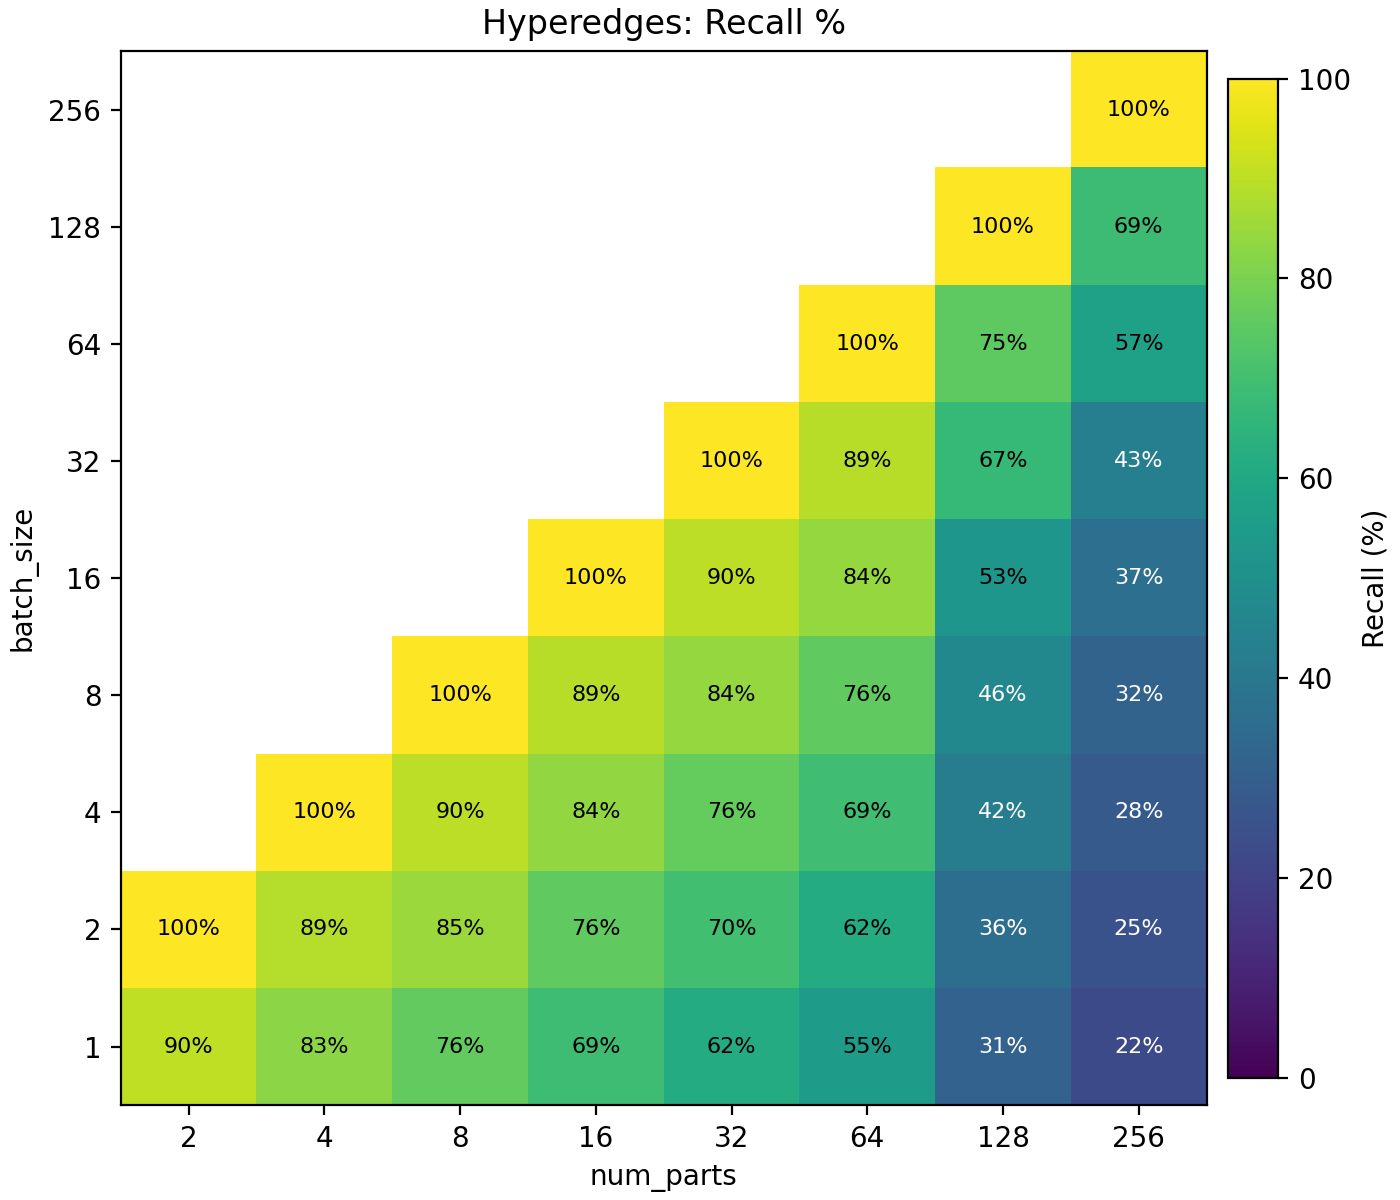

### Recall after a single epoch for the Cora cell complex

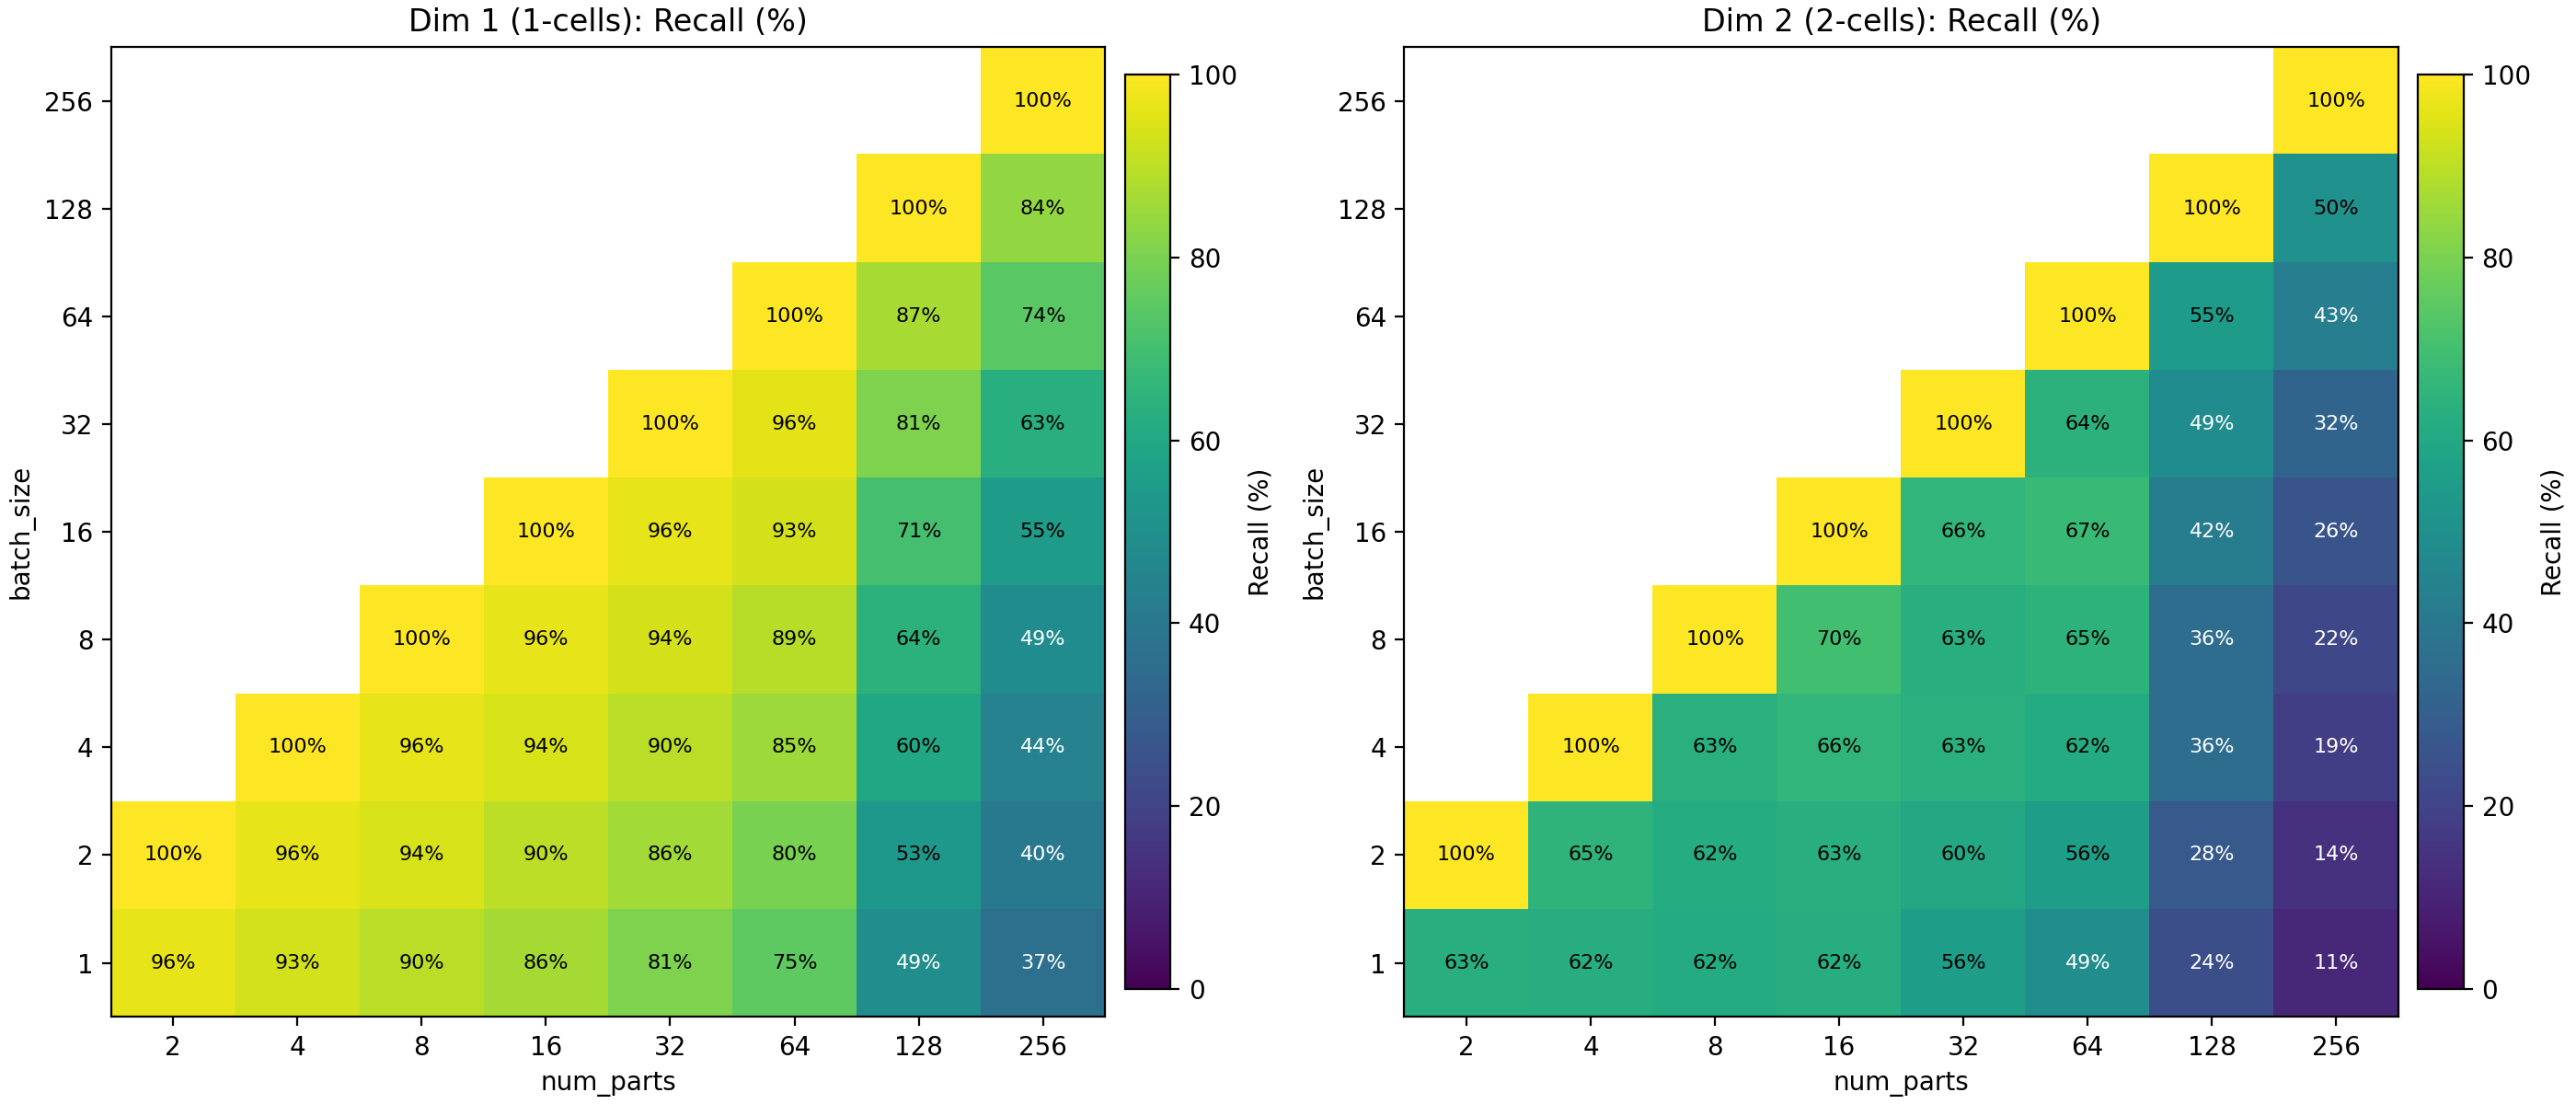

### Recall after 100 epochs for the Cora hypergraph

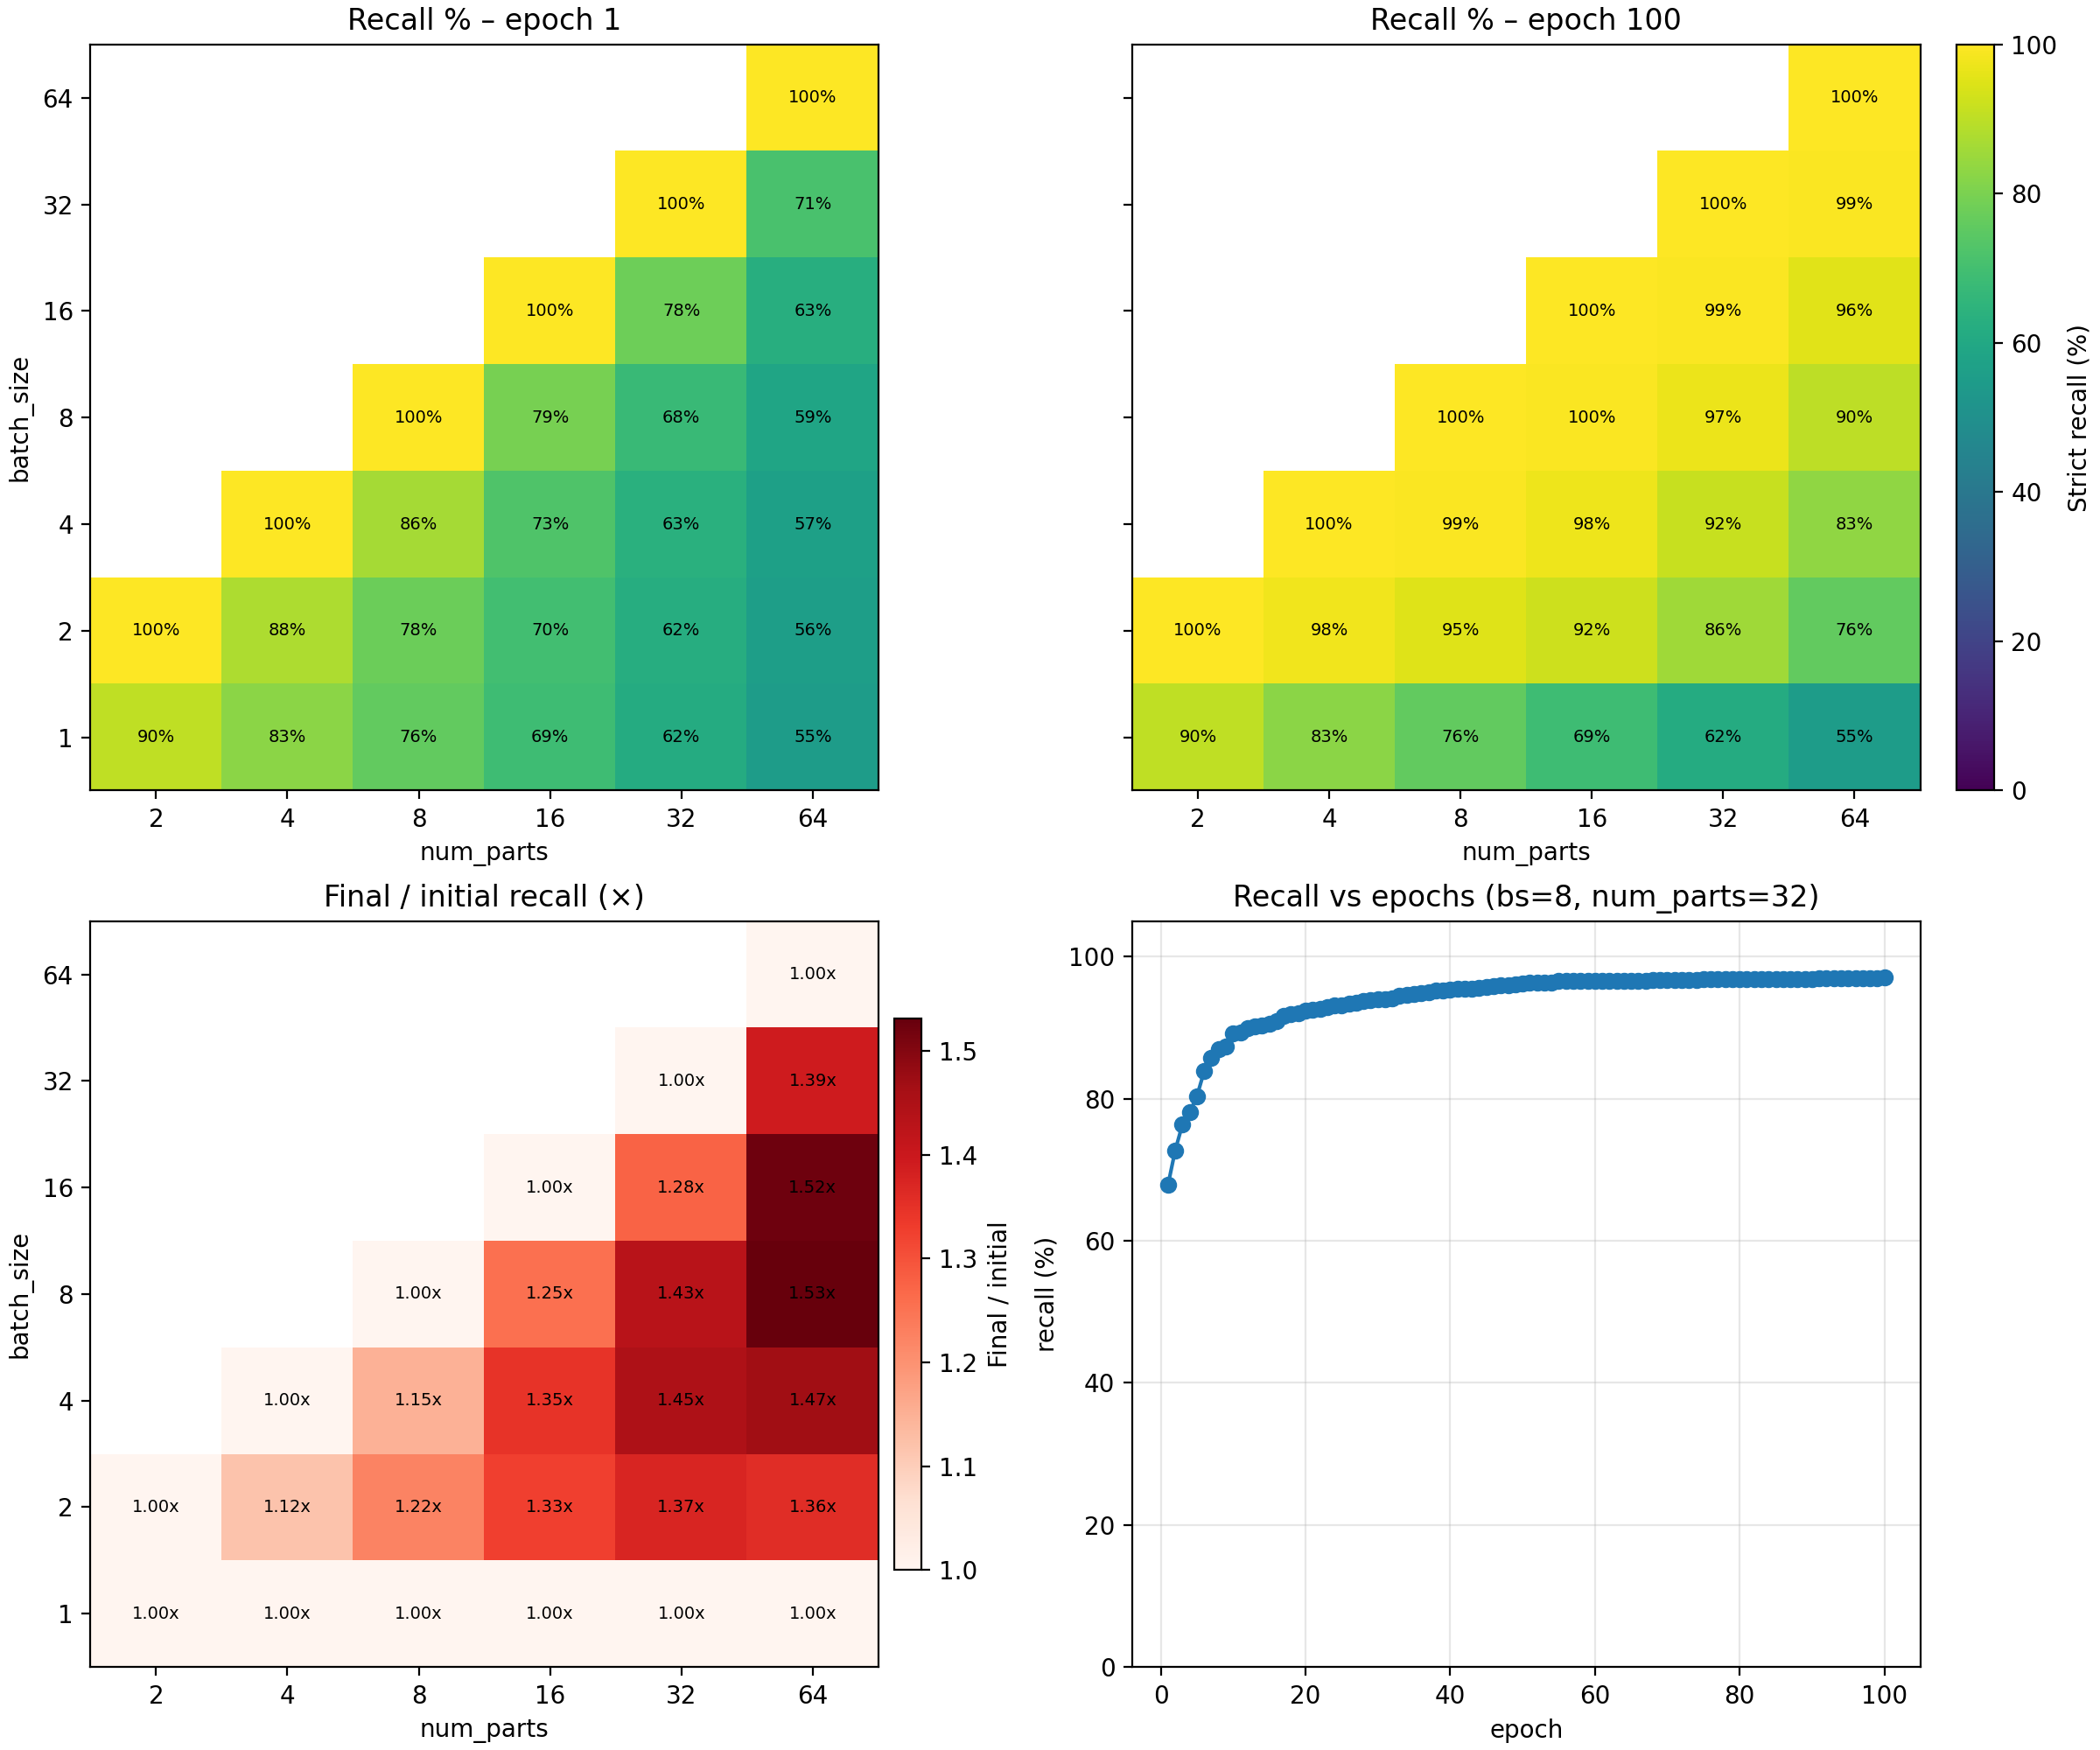

### Recall after 100 epochs for the Cora cell complex

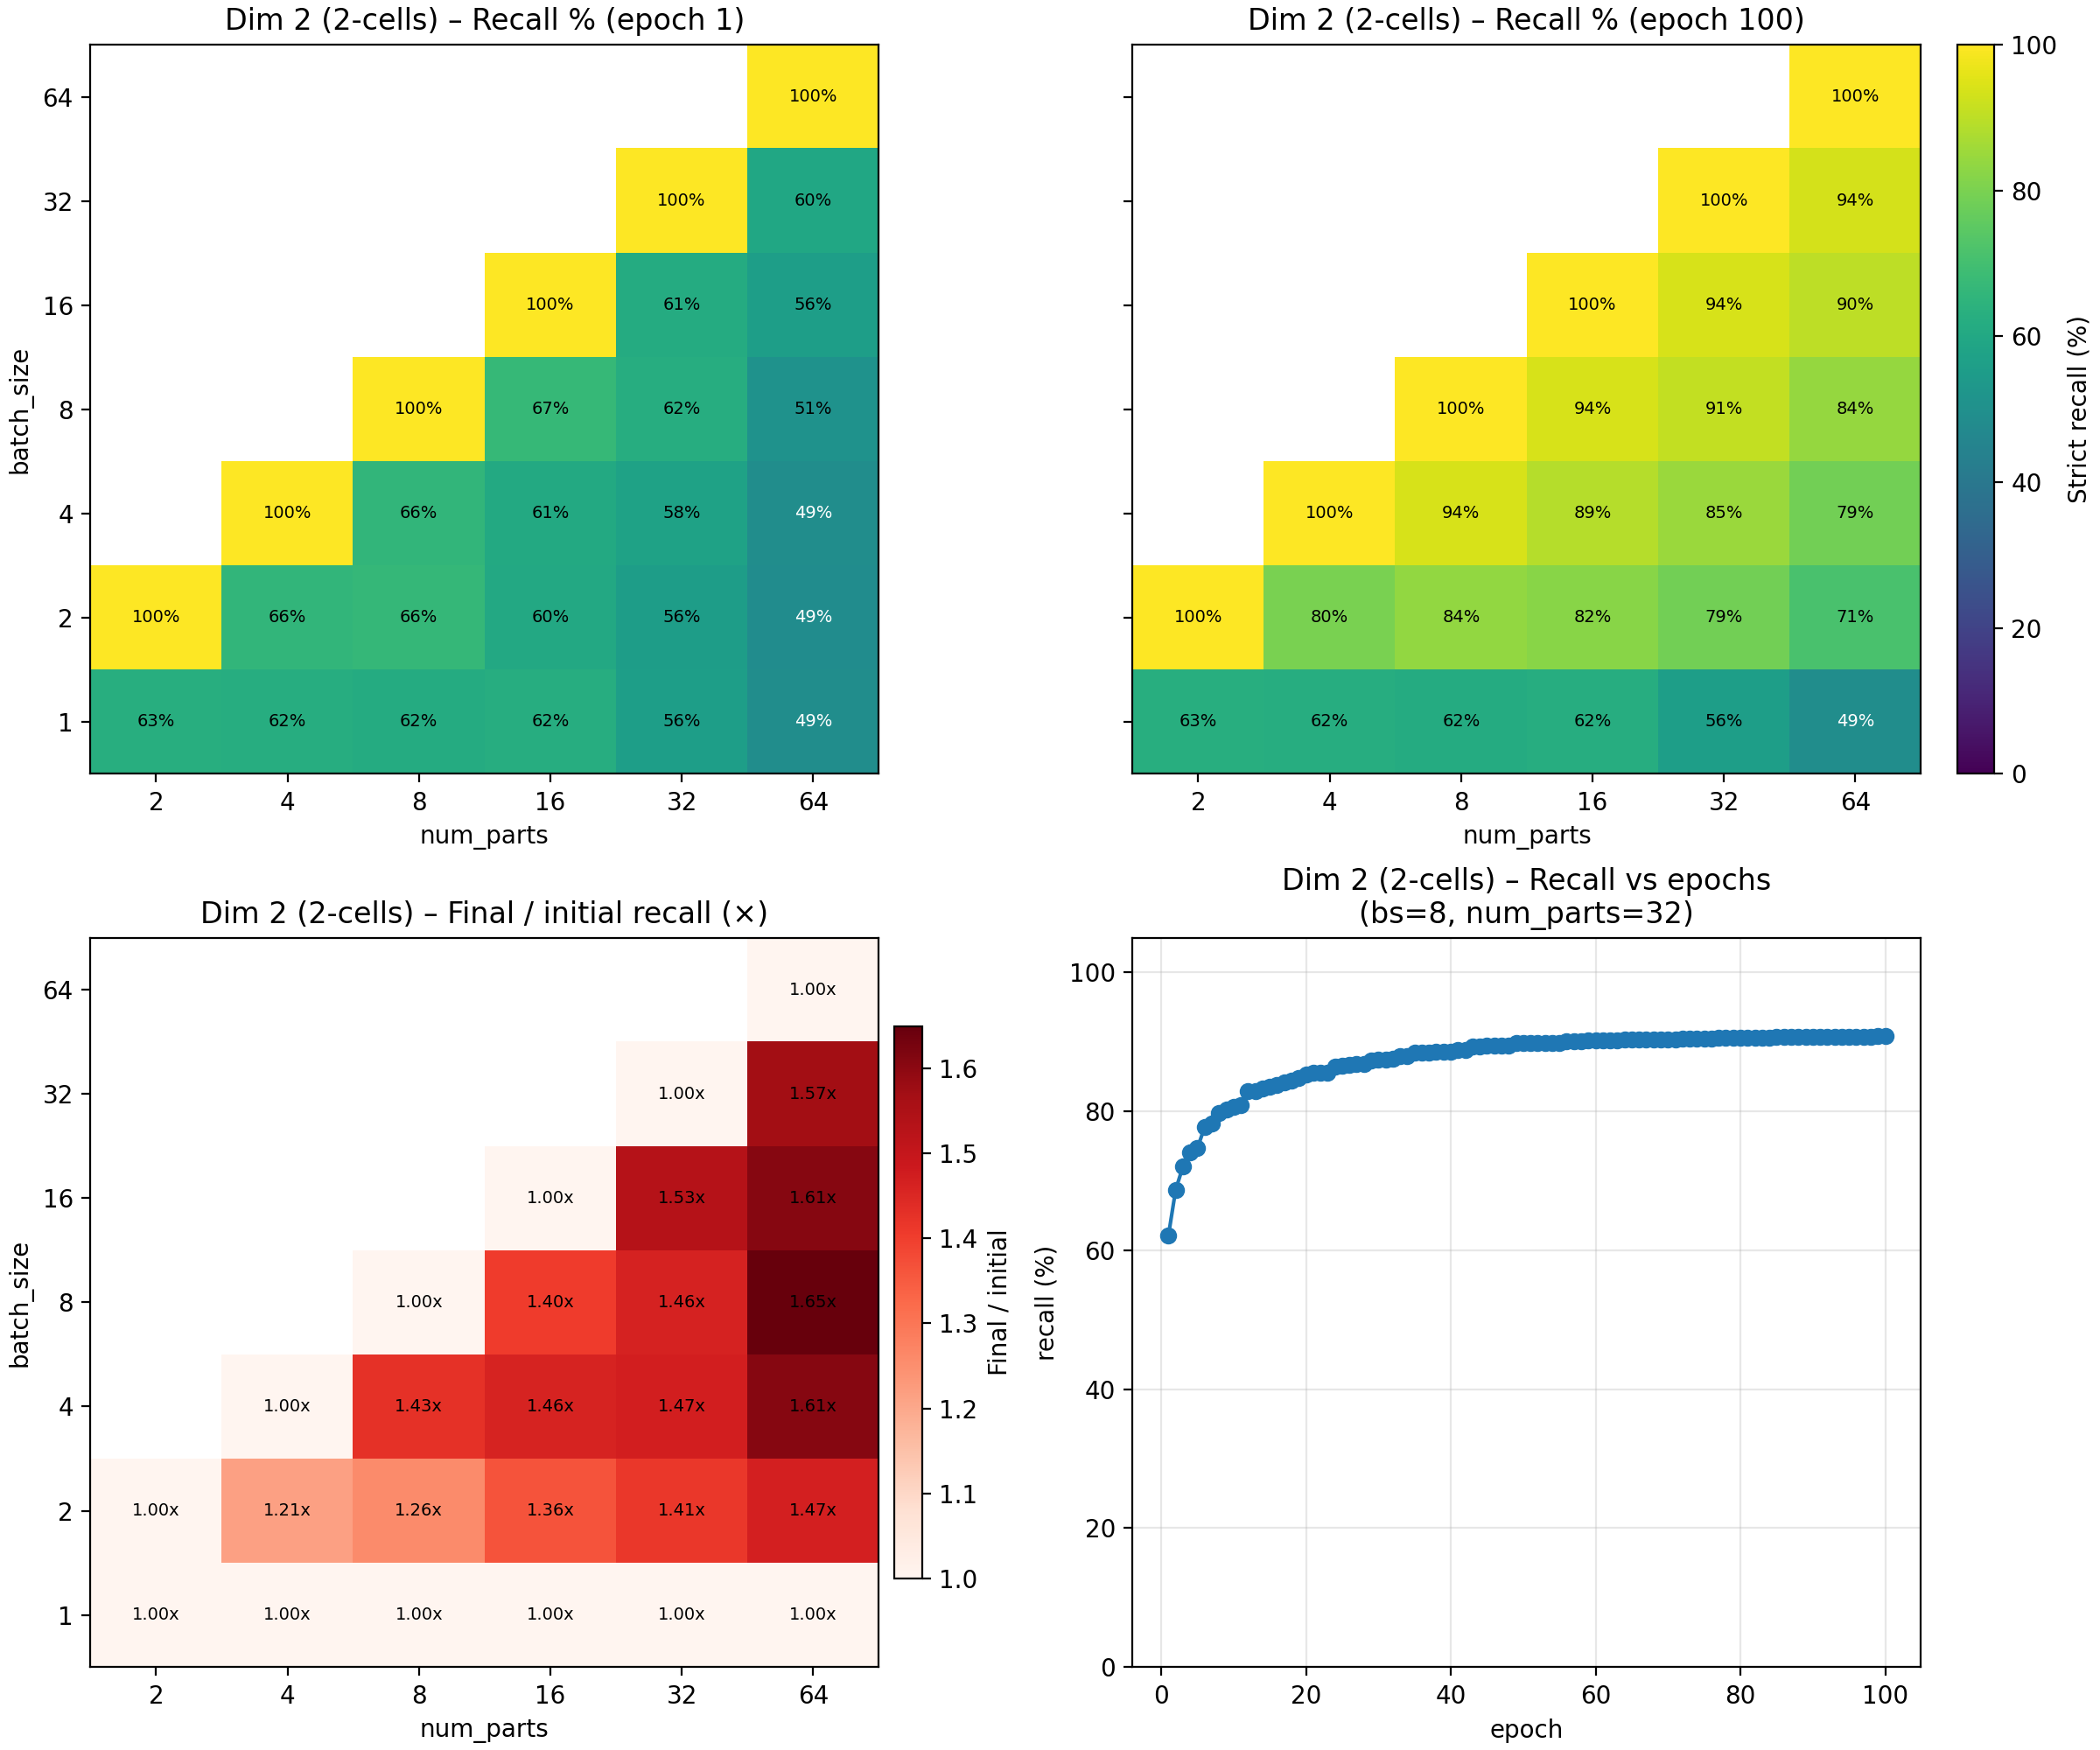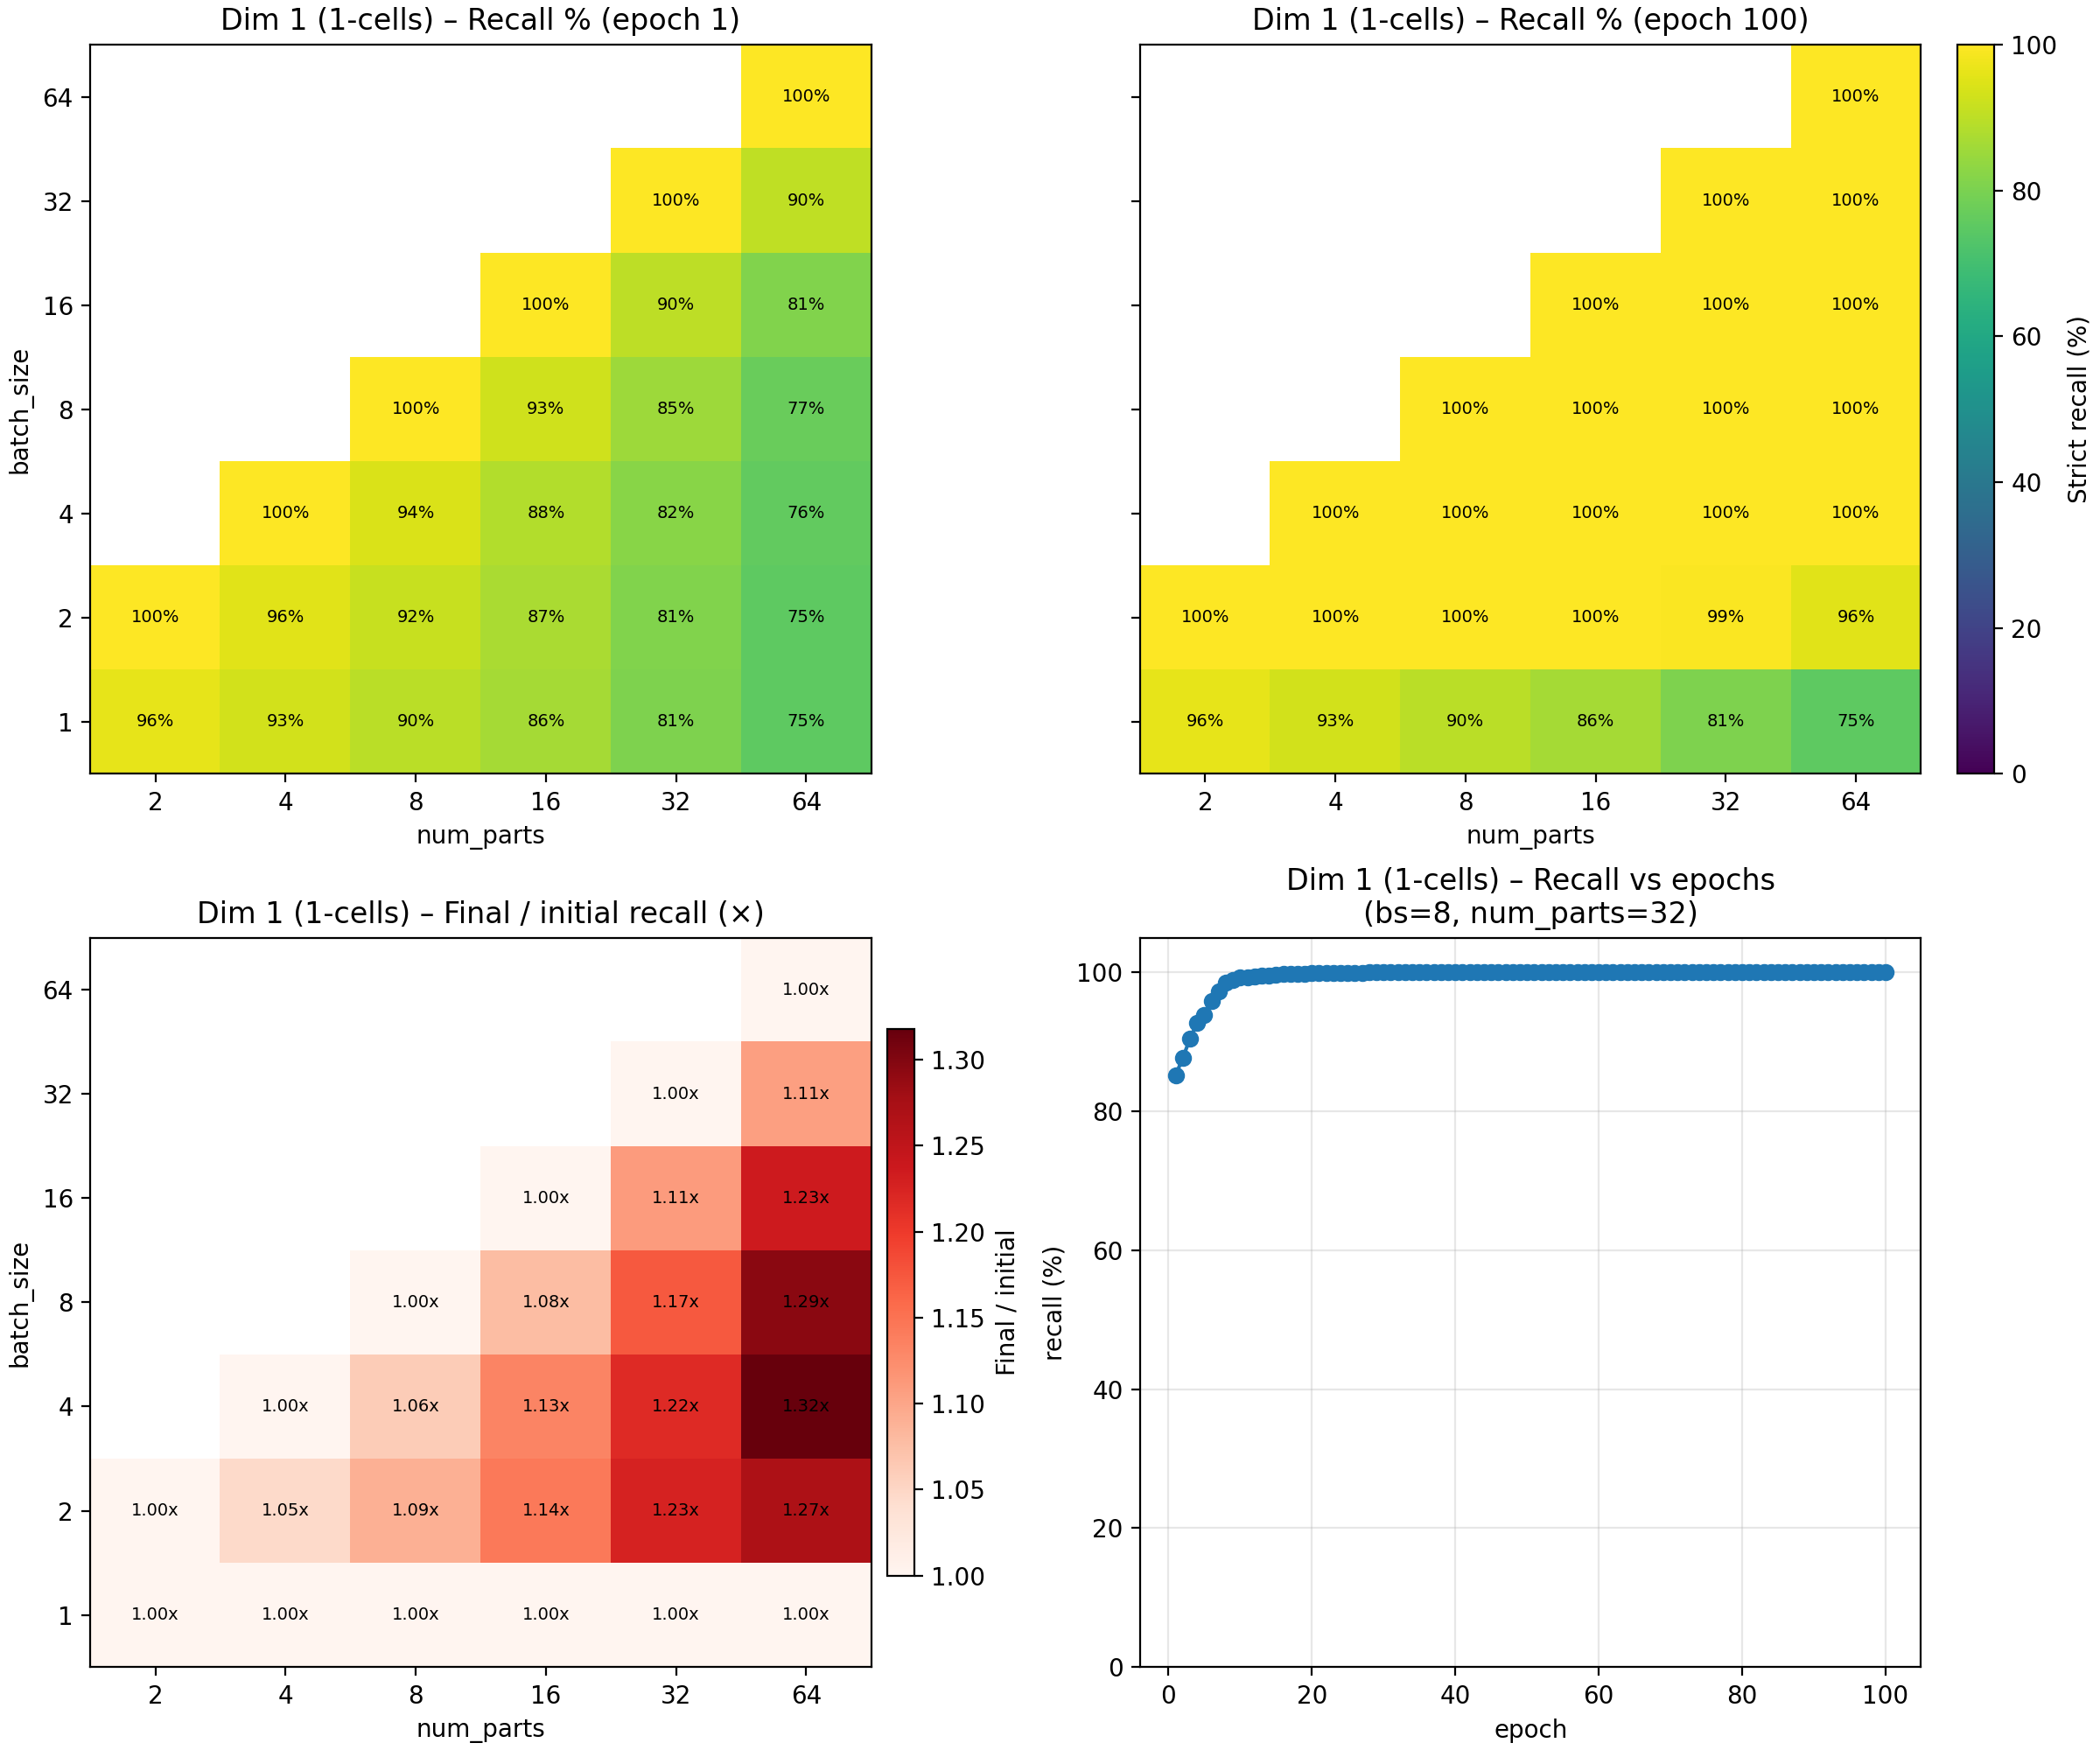

These experiments show that, although partitioning the graph inevitably breaks some global higher-order structures, batch-level liftings combined with randomized Cluster-GCN batching recover the vast majority of them over multiple epochs.

Even when the graph is heavily partitioned, the model gradually encounters different combinations of clusters across epochs. As a result:

- recall after a single epoch already captures a substantial portion of the global structures,
- cumulative recall over many epochs approaches the golden lifting,
- and the improvement (final / initial recall) can be significant in higher dimensions.

This confirms that our design choice to perform liftings on the collated batch rather than inside each cluster, preserves global topology.

### Further Use and Reproducibility

All results shown in this section were generated using four utility scripts:

- `sweep_cells.py`
- `sweep_hypergraphs.py`
- `sweep_over_epochs_cells.py`
- `sweep_over_epochs_hypergraphs.py`

Each script produces heatmaps or epoch-wise recall plots for a chosen dataset.

These scripts can be easily adapted to your own experiments by modifying:

- the dataset name (e.g., Cora, PubMed, Reddit),
- the list of `num_parts` values (number of METIS partitions),
- the list of `batch_size` values (number of partitions per batch),
- and, for the epoch-based sweeps, the number of epochs to run.

the scripts automatically regenerate the necessary lifted structures and overwrite cached results when parameters change.

## Bonus: memory usage comparisons accross different models

For another cocitation dataset, PubMed, we evaluated three pipelines using four different model domains: graph, hypergraph, cell complexes, and simplicial complexes.

1. **cocitation\_pubmed (in-memory)**: Standard PyG `InMemoryDataset`  

2. **cocitation\_pubmed\_cluster (partitioning pipeline)**: Produced with Pipeline 2 (`on_disk_cluster`)  

3. **cocitation\_pubmed\_cluster\_2 (fully on-disk pipeline)**: Produced with Pipeline 3 (`on_disk`)

### `graph/gcn` model

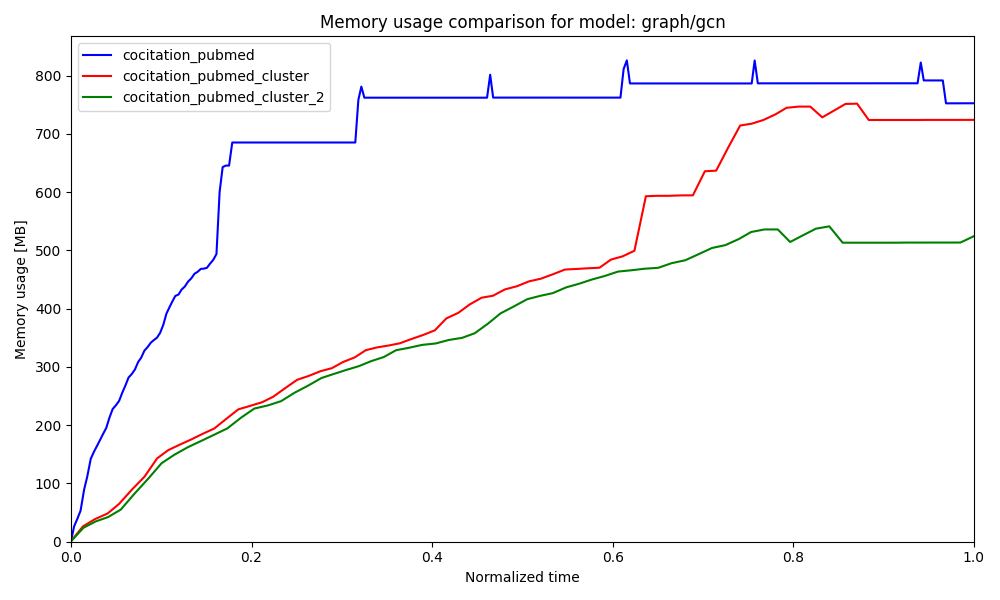

### `hypergraph/edgnn` model

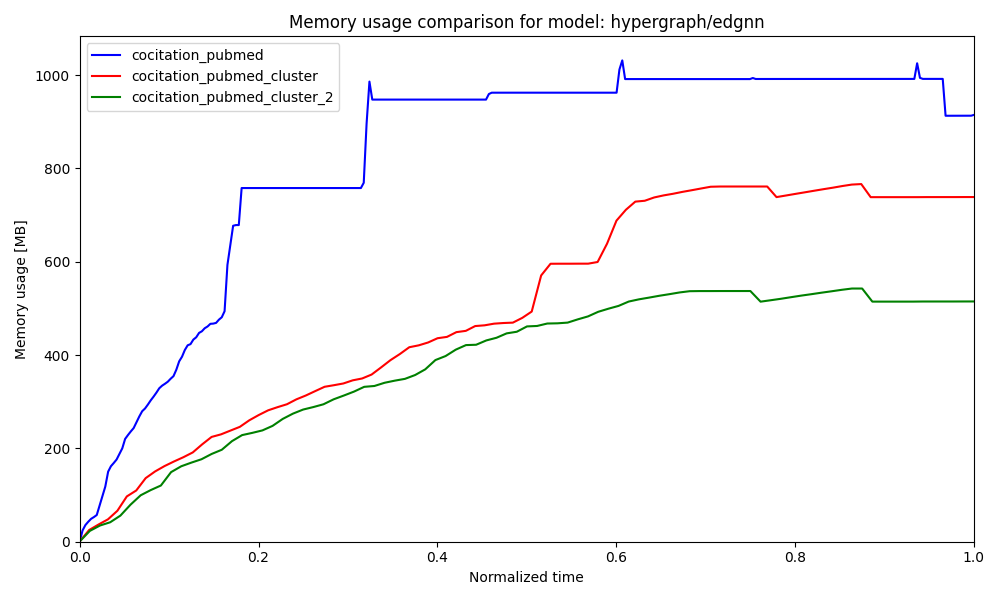

### `cell/topotune` model

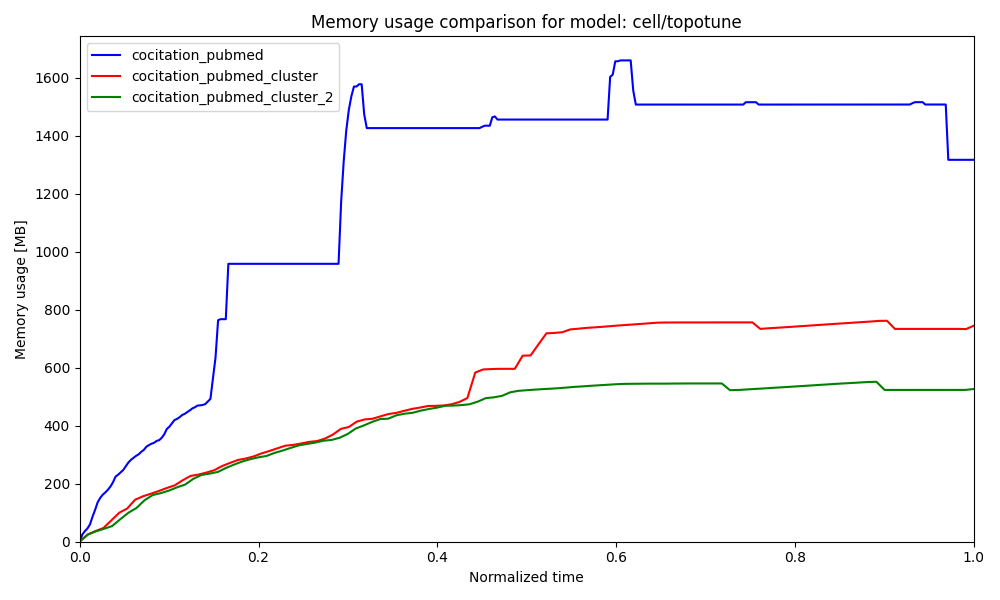

### `simplicial/topotune` model

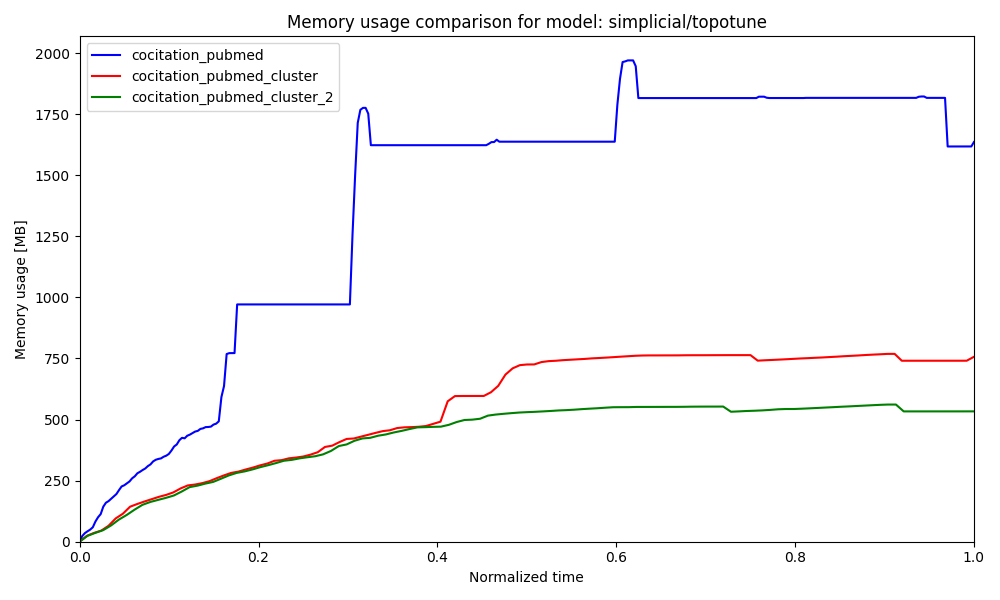